## Objective

**Cryptocurrency prediction experiment** to predict direction of the close price of BTCUSDT for the next 10 hours

Dataset:
- BTCUSDT 1h in Json format from Binance

Prediction target logic:
- Set treshold to +-1%
- If next 10 hours close price is higher than 1% of current close price, label as 1
- If next 10 hours close price is lower than -1% of current close price, label as -1
- Else label as 0

Since we focus on the direction of the price, we will use classification model for this experiment

In [54]:
import pandas as pd

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')

    # change datetime to index
    df.set_index('datetime', inplace=True)
    
    df = remove_outlier(df)
    return df

random_state = 55

## Feature Engineering

In [55]:
df = read_hist_data(name = 'BTC', timeframe = '1h') # read data
# df = read_hist_data(name = 'BTC', timeframe = '5m') # read data

# prediction target = close % change
df['target_pct'] = df['close'].pct_change()

print(df.head(10))
print(df.tail(10)) 



df.describe()

                         open      high       low     close       volume  \
datetime                                                                   
2021-01-01 00:00:00  28923.63  29031.34  28690.17  28995.13  2311.811445   
2021-01-01 01:00:00  28995.13  29470.00  28960.35  29409.99  5403.068471   
2021-01-01 02:00:00  29410.00  29465.26  29120.03  29194.65  2384.231560   
2021-01-01 03:00:00  29195.25  29367.00  29150.02  29278.40  1461.345077   
2021-01-01 04:00:00  29278.41  29395.00  29029.40  29220.31  2038.046803   
2021-01-01 05:00:00  29220.31  29235.28  29084.11  29187.01  1469.956262   
2021-01-01 06:00:00  29187.01  29270.00  29077.32  29174.35  1420.726291   
2021-01-01 07:00:00  29174.35  29191.98  28806.54  29092.83  2380.180918   
2021-01-01 08:00:00  29092.84  29178.03  28872.24  29000.01  2008.165739   
2021-01-01 09:00:00  29000.01  29307.73  28970.00  29202.21  2022.056022   

                     target_pct  
datetime                         
2021-01-01 00:00:00

,open,high,low,close,volume,target_pct
count,22915.000000,22915.000000,22915.000000,22915.000000,22915.000000,22914.000000
mean,35117.336473,35297.705123,34928.163154,35117.620848,4477.749672,0.000023
std,13125.131469,13210.580569,13033.198250,13125.379765,4697.700455,0.007451
min,15648.230000,15769.990000,15476.000000,15649.520000,5.887034,-0.105017
25%,23415.510000,23483.855000,23341.975000,23414.470000,1398.628235,-0.002710
50%,32099.970000,32345.000000,31800.000000,32099.980000,2658.617538,0.000025
75%,45197.645000,45485.530000,44869.145000,45197.975000,5828.032940,0.002775
max,68635.120000,69000.000000,68451.190000,68633.690000,28721.893750,0.123159


### Experiment 1: Create features from indicators

Use TAlib (Technical Analysis Library) in Python to create technical indicators that might have prediction power.
- Set `target` by using 25% level of target population as a threshold to determine direction of the price
- We will explore all available data which is Open, High, Low, Close, Volume
- We will focus in index type indicators since it's more generalizable to other stocks


In [120]:
import numpy as np
import pandas as pd

# to predict if the price will go up or down in the next period
def get_target_next_close(df, target_shift = 1):

    target_threshold = 0.003

    # future pct change of Close
    df['target_pct'] = df['close'].pct_change()
    
    # shift target in future by target_shift
    df['target_pct'] = df['target_pct'].shift(target_shift * -1)
   
    conditions = [
        (df['close'].shift(target_shift * -1).isnull()), 
        (df['close'].shift(target_shift * -1) > df['close'] * (1+target_threshold )),
        (df['close'].shift(target_shift * -1) < df['close'] * (1-target_threshold))
    ]
    values = [np.nan, 1, -1]
    df['target'] = np.select(conditions, values, default=0)
    
    return df

# df = read_hist_data()
# df = get_target_next_close(df)

# print(df.head(5))
# print(df.tail(5))

The features are derived from various technical indicators, such as the percentage of change, Exponential Moving Averages (EMA), Relative Strength Index (RSI), and others over multiple periods. The features are calculated using the `ta` library.

In [145]:
import talib
import numpy as np
import warnings

def get_features(df):
    df = df.copy()

    # List of periods
    periods = [5, 10, 20, 40, 80]
    inputs = ['open', 'high', 'low', 'close', 'volume']

    # log volume
    df['volume'] = np.log(df['volume'])
    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
        
        
            # Generate indicators

            # % of change
            df.loc[:, f'{input}_pct_{period}'] = df[input].pct_change(periods=period)

            # EMAs
            df.loc[:, f'{input}_ema_{period}'] = talib.EMA(df[input].values, timeperiod=period)

            # RSI
            df.loc[:, f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            df.loc[:, f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            df.loc[:, f'{input}_sd_{period}'] = talib.STDDEV(df[input].values, timeperiod=period)

            # ROC
            df.loc[:, f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df.loc[:, f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)


        df = df.copy()
        
        # Multiple inputs indicators
        # ATR
        atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df.loc[:, f'price_atr_{period}'] = atr

        # Price interaction Features:
        df.loc[:, f'price_interact_{period}'] = df[f'close_pct_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df.loc[:, f'pv_interact_{period}'] = df[f'close_pct_{period}'] * df[f'volume_pct_{period}']

        # ADX
        df.loc[:, f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df.loc[:, f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df.loc[:, f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

    df = df.copy()
    
    return df

df = read_hist_data()
df = get_target_next_close(df)
df = get_features(df)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

# Count target values
print("Count", df['target'].value_counts())

print("Shape", df.shape)

df.describe()

Count target
 0.0    12098
 1.0     5335
-1.0     5243
Name: count, dtype: int64
Shape (22676, 212)


,open,high,low,close,volume,target_pct,target,open_pct_5,open_ema_5,open_rsi_5,...,volume_trix_80,volume_sd_80,volume_roc_80,volume_var_80,price_atr_80,price_interact_80,pv_interact_80,price_adx_80,mfi_80,price_dx_80
count,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,...,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000
mean,35119.474608,35297.924274,34932.766292,35119.358703,7.956264,0.000010,0.004057,0.000048,35120.544755,50.107491,...,-0.000756,0.507078,0.527117,0.271079,369.674408,-1.122671,-0.000306,13.488741,50.222947,13.596653
std,13187.442326,13273.257147,13095.169048,13187.740972,0.947552,0.007358,0.683000,0.016292,13183.542564,18.947606,...,0.029637,0.118117,11.124851,0.131423,240.670289,35.640334,0.007603,6.115836,5.729443,10.640867
min,15648.230000,15769.990000,15476.000000,15649.520000,1.772752,-0.105017,-1.000000,-0.139675,15735.204649,1.121960,...,-0.142974,0.271230,-77.445199,0.073566,37.364503,-317.718029,-0.097869,3.709515,31.638686,0.000563
25%,23358.705000,23439.325000,23269.340000,23355.080000,7.235698,-0.002691,0.000000,-0.006021,23365.200187,36.863903,...,-0.018797,0.415276,-6.567653,0.172454,162.803224,-9.242100,-0.001890,9.130853,46.185918,5.343820
50%,31883.545000,32163.280000,31671.145000,31881.755000,7.877857,0.000021,0.000000,0.000005,31941.809892,50.137025,...,-0.001035,0.483974,-0.101862,0.234231,315.535000,-0.103217,-0.000005,11.921938,50.032979,11.197398
75%,45445.780000,45776.395000,45150.000000,45445.790000,8.670391,0.002747,0.000000,0.006117,45479.773576,63.247994,...,0.016359,0.586128,6.872177,0.343546,538.664388,10.468266,0.001707,16.205516,54.030398,19.276040
max,68635.120000,69000.000000,68451.190000,68633.690000,10.265415,0.123159,1.000000,0.185445,68225.516624,98.827914,...,0.124158,0.990415,330.676978,0.980922,1290.661348,227.240465,0.309765,40.244988,69.827068,74.174616


##### Identify the most important features

When dealing with a large number of features, it's crucial to determine which features are most relevant for predicting your target variable. Feature selection techniques can help you identify the most relevant features, reduce overfitting, improve accuracy, and reduce training time. We will use a **Tree-Based Model** to rank the importance of each feature.

**Sort importance of features of Close price change (Regression)**

In [146]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data into train and test sets
drop_columns = ['target', 'target_pct']
X = df.drop(columns=drop_columns)
y = df['target_pct']

random_state = 55

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

model = RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=55)

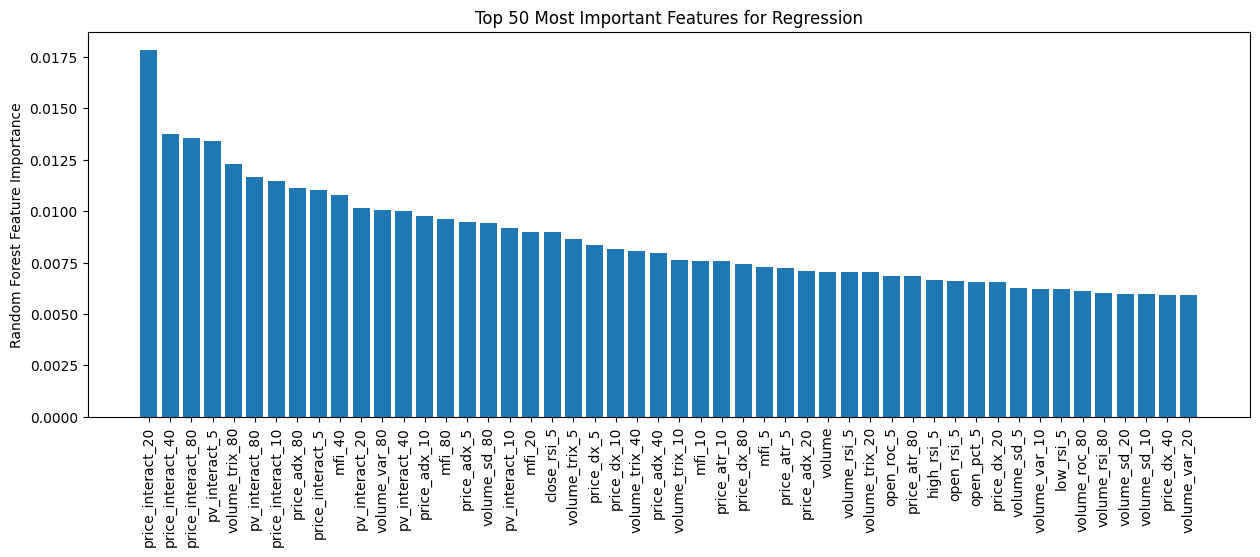

In [147]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]  # Reverse the sorting order

# Get top 50 features
top_50_indices = sorted_idx[:50]
top_50_importances = importances[top_50_indices]
top_50_features_regression = X.columns[top_50_indices]

plt.figure(figsize=(15, 5))
plt.bar(top_50_features_regression, top_50_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Top 50 Most Important Features for Regression")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

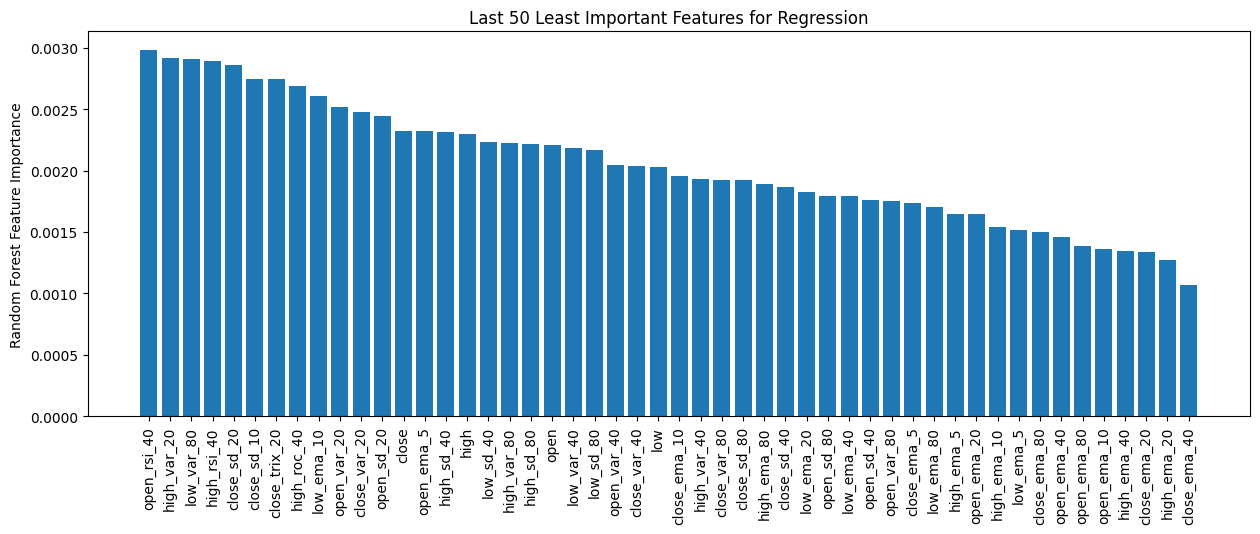

In [148]:
# Get last 50 features
last_50_indices = sorted_idx[-50:]
last_50_importances = importances[last_50_indices]
last_50_features_regression = X.columns[last_50_indices]

plt.figure(figsize=(15, 5))
plt.bar(last_50_features_regression, last_50_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Last 50 Least Important Features for Regression")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

In [149]:
# Evaluate model with mean_squared_error
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Regression - Mean Squared Error: {mse:.6f}")

Regression - Mean Squared Error: 0.000125


In [150]:
print("top_50_features_regression =", top_50_features_regression)
print("last_50_features_regression =",last_50_features_regression)

top_50_features_regression = Index(['price_interact_20', 'price_interact_40', 'price_interact_80',
       'pv_interact_5', 'volume_trix_80', 'pv_interact_80',
       'price_interact_10', 'price_adx_80', 'price_interact_5', 'mfi_40',
       'pv_interact_20', 'volume_var_80', 'pv_interact_40', 'price_adx_10',
       'mfi_80', 'price_adx_5', 'volume_sd_80', 'pv_interact_10', 'mfi_20',
       'close_rsi_5', 'volume_trix_5', 'price_dx_5', 'price_dx_10',
       'volume_trix_40', 'price_adx_40', 'volume_trix_10', 'mfi_10',
       'price_atr_10', 'price_dx_80', 'mfi_5', 'price_atr_5', 'price_adx_20',
       'volume', 'volume_rsi_5', 'volume_trix_20', 'open_roc_5',
       'price_atr_80', 'high_rsi_5', 'open_rsi_5', 'open_pct_5', 'price_dx_20',
       'volume_sd_5', 'volume_var_10', 'low_rsi_5', 'volume_roc_80',
       'volume_rsi_80', 'volume_sd_20', 'volume_sd_10', 'price_dx_40',
       'volume_var_20'],
      dtype='object')
last_50_features_regression = Index(['open_rsi_40', 'high_var_20', '

**Sort importance of features of Close price level (Classification)**

In [151]:
from sklearn.ensemble import RandomForestClassifier

# Pre data for classification
drop_columns = ['target', 'target_pct']
X = df.drop(columns=drop_columns)
y = df['target']

random_state = 55

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

model = RandomForestClassifier(random_state=random_state, n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=55)

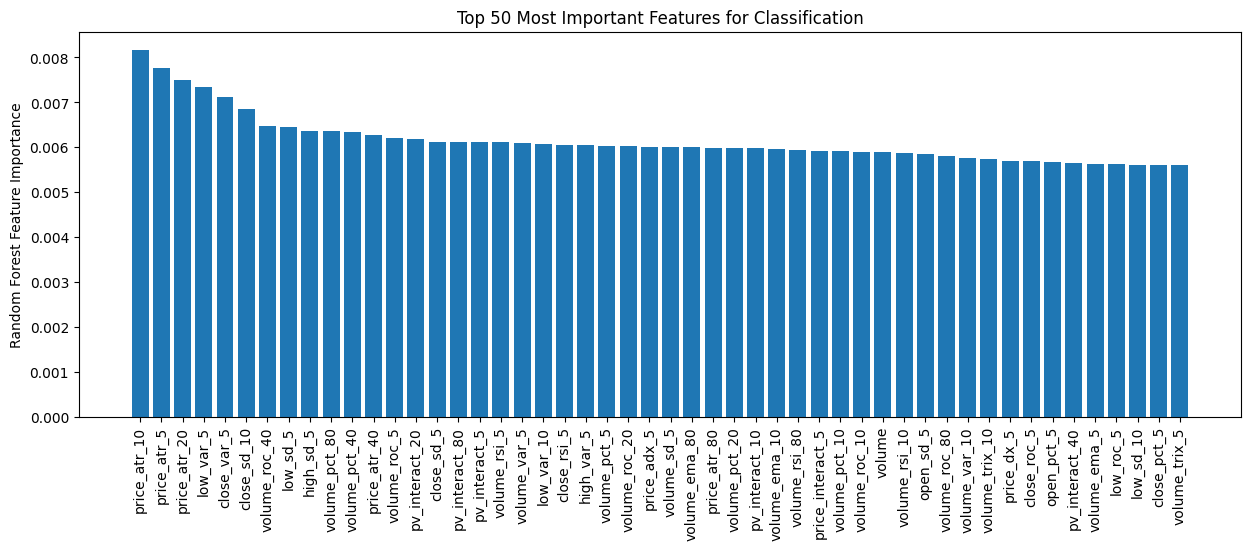

In [152]:
importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]  # Reverse the sorting order

# Get top 50 features
top_50_indices = sorted_idx[:50]
top_50_importances = importances[top_50_indices]
top_50_features_classification = X.columns[top_50_indices]

plt.figure(figsize=(15, 5))
plt.bar(top_50_features_classification, top_50_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Top 50 Most Important Features for Classification")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

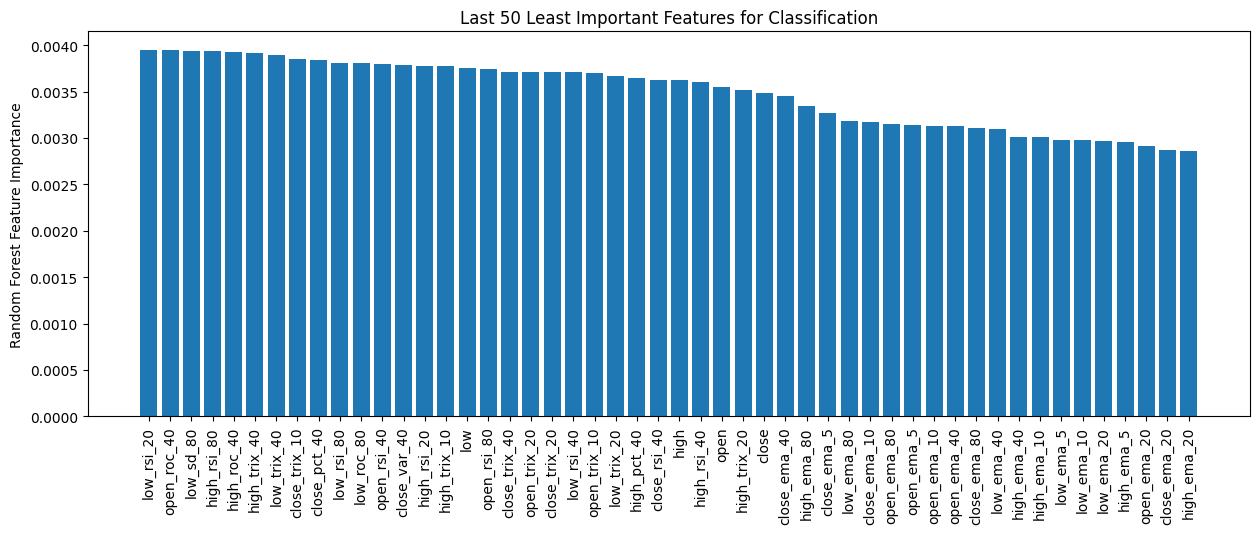

In [153]:
# Get last 50 features
last_50_indices = sorted_idx[-50:]
last_50_importances = importances[last_50_indices]
last_50_features_classification = X.columns[last_50_indices]

plt.figure(figsize=(15, 5))
plt.bar(last_50_features_classification, last_50_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Last 50 Least Important Features for Classification")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

In [154]:
print("top_50_features_classification =", top_50_features_classification)
print("last_50_features_classification =",last_50_features_classification)

top_50_features_classification = Index(['price_atr_10', 'price_atr_5', 'price_atr_20', 'low_var_5',
       'close_var_5', 'close_sd_10', 'volume_roc_40', 'low_sd_5', 'high_sd_5',
       'volume_pct_80', 'volume_pct_40', 'price_atr_40', 'volume_roc_5',
       'pv_interact_20', 'close_sd_5', 'pv_interact_80', 'pv_interact_5',
       'volume_rsi_5', 'volume_var_5', 'low_var_10', 'close_rsi_5',
       'high_var_5', 'volume_pct_5', 'volume_roc_20', 'price_adx_5',
       'volume_sd_5', 'volume_ema_80', 'price_atr_80', 'volume_pct_20',
       'pv_interact_10', 'volume_ema_10', 'volume_rsi_80', 'price_interact_5',
       'volume_pct_10', 'volume_roc_10', 'volume', 'volume_rsi_10',
       'open_sd_5', 'volume_roc_80', 'volume_var_10', 'volume_trix_10',
       'price_dx_5', 'close_roc_5', 'open_pct_5', 'pv_interact_40',
       'volume_ema_5', 'low_roc_5', 'low_sd_10', 'close_pct_5',
       'volume_trix_5'],
      dtype='object')
last_50_features_classification = Index(['low_rsi_20', 'open_roc_40

In [156]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average if classes are imbalanced
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:0.4f}")
print(f"F1-Score: {f1:0.4f}")
print(f"Precision: {precision:0.4f}")
print(f"Recall: {recall:0.4f}")

Accuracy: 0.6825
F1-Score: 0.6424
Precision: 0.6166
Recall: 0.6825


##### Features importance interpretation:

**Classification Model:**

**Objective**: The classification model aims to predict the level of return for the next hour. The three classes represent:
- **1**: An increase greater than a specified threshold.
- **-1**: A decrease greater than the threshold.
- **0**: Changes within the threshold.

**Model Performance**:
- **Accuracy**: 68.25%. This means that out of all the predictions made, about 68.25% were correct. 
- **F1-Score**: 64.24%. F1-Score is the harmonic mean of precision and recall, and a score of 64.24% suggests a balanced performance in terms of false positives and false negatives.
- **Precision**: 61.66%. This tells us that when the model predicts an increase or decrease, it's correct about 61.66% of the time.
- **Recall**: 68.25%. This suggests that of all actual price movements that should have been classified correctly, the model caught about 68.25% of them.

Key features for this model are primarily based on `price volatility` metrics (`price_atr_...`, `close_sd_...`, and `close_var_...`). The combined effects of price and volume movements (`pv_interact_...` and `volume_ema_...`) also appear to be significant predictors.

**Regression Model:**

**Objective**: The regression model predicts the continuous return for the next hour.

**Model Performance**:
- **Mean Squared Error (MSE)**: 0.000125, A low MSE suggests that the model's predictions are relatively close to the actual values. Without more context, it's hard to determine if this is a good MSE value, but in general, a lower MSE indicates better performance.

The top features for this model emphasize the importance of price interactions (`Close * ATR`) with various metrics (`price_interact_...`). The interactions of volume and price (`pv_interact_...`), along with specific metrics like `volume_trix_...` and `mfi_...`, play a significant role in predicting BTCUSDT returns.

**Summary:**
1. **Classification Model**: With an accuracy of nearly 70%, the model performs reasonably well in predicting the direction and magnitude of the next hour's return based on the threshold. The features that stand out are those related to price `volatility` and `interactions between volume and price`. 
   
2. **Regression Model**: The model's predictions are relatively close to actual returns, as indicated by the MSE. Key predictors include `price interactions` and `volume-price interactions`.

----

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is the DataFrame with features and target variable
# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Initialize and train the model
clf = RandomForestClassifier(random_state=random_state)
clf.fit(X_train, y_train)

# Get feature importances
feature_importances = clf.feature_importances_

# Sort feature importances in descending order and get the indices
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
feature_names = [X.columns[i] for i in indices]



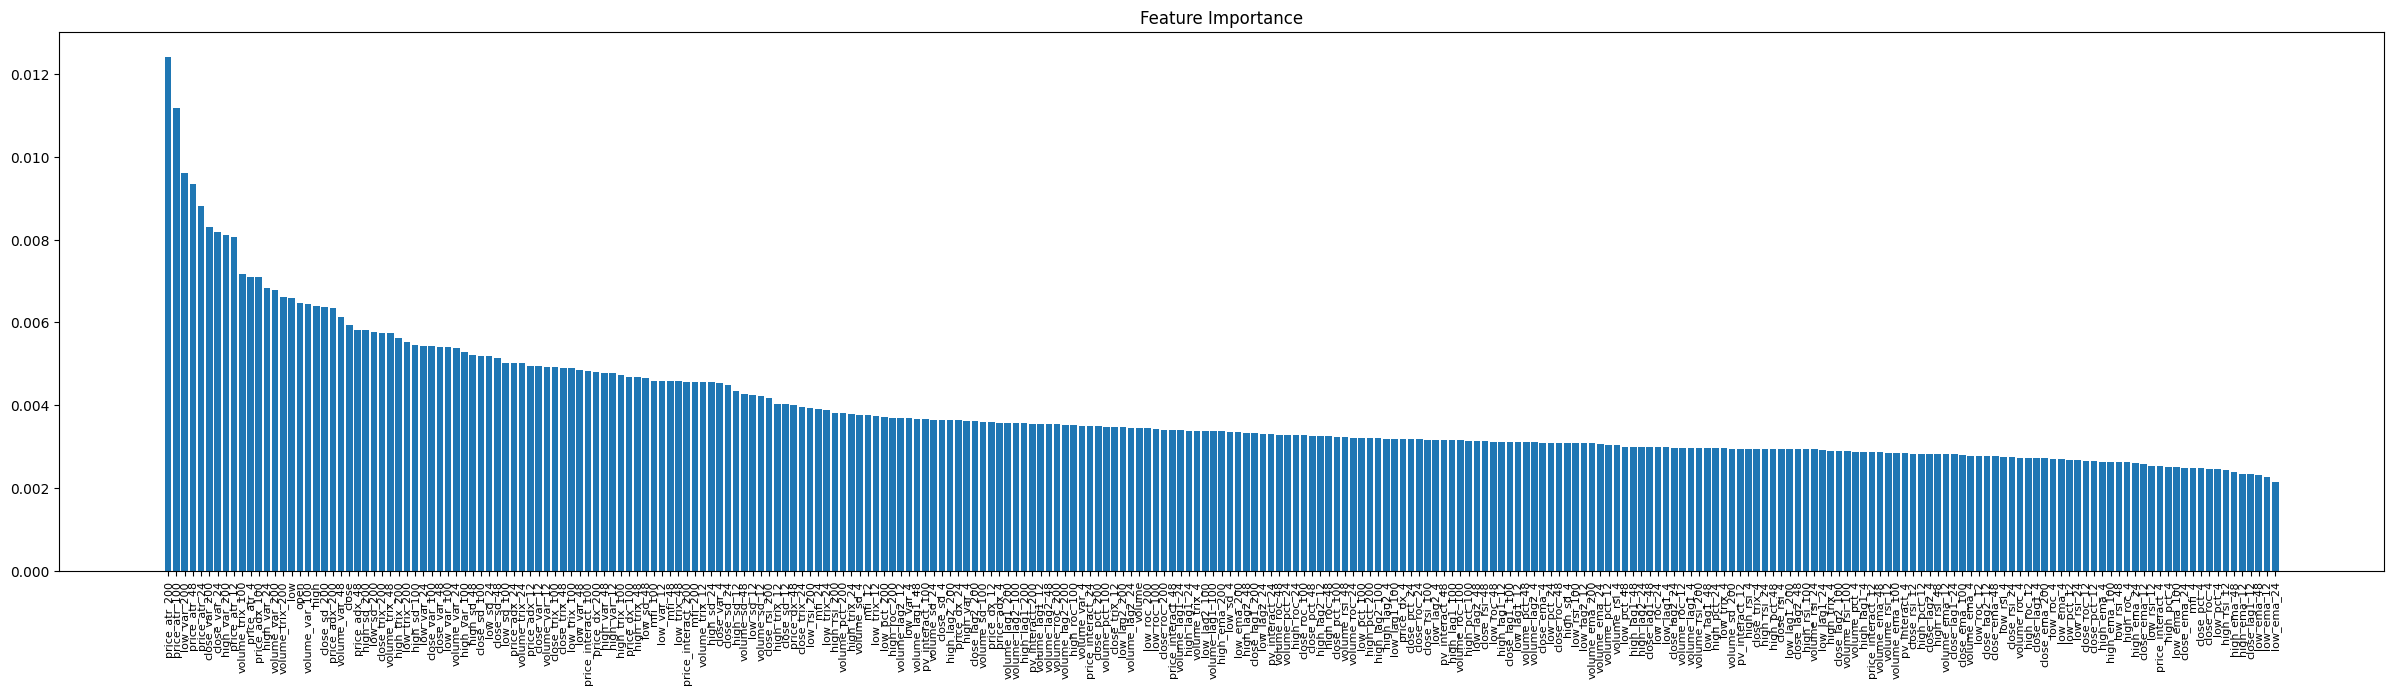

Total features: 257
Top 25 important features:  ['price_atr_200', 'price_atr_100', 'low_var_200', 'price_atr_48', 'price_atr_24', 'close_var_200', 'close_var_24', 'high_var_200', 'price_atr_12', 'volume_trix_100', 'price_atr_4', 'price_adx_100', 'high_var_24', 'volume_var_200', 'volume_trix_200', 'low', 'open', 'volume_var_100', 'high', 'close_sd_200', 'price_adx_200', 'volume_var_48', 'close', 'price_adx_48', 'high_sd_200']
Least 25 important features:  ['low_rsi_24', 'close_roc_12', 'close_pct_12', 'high_ema_4', 'high_ema_100', 'low_rsi_48', 'high_roc_4', 'high_ema_24', 'close_ema_12', 'low_rsi_12', 'price_interact_4', 'high_pct_4', 'low_ema_100', 'close_ema_24', 'mfi_4', 'close_pct_4', 'close_roc_4', 'low_pct_4', 'high_rsi_12', 'high_ema_48', 'high_ema_12', 'close_lag1_12', 'low_ema_48', 'low_ema_12', 'low_ema_24']


In [24]:
# Create a plot
plt.figure(figsize=(30, 7))

# Create plot title
plt.title("Feature Importance")

# Add bars for each feature, small font size to fit the features
plt.bar(range(X.shape[1]), feature_importances[indices] )

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), feature_names, rotation=90, fontsize = 8)

# Show plot
plt.show()

# print total features
print(f'Total features: {len(feature_names)}')

# print most important 25 features
print("Top 25 important features: ", feature_names[:25])

# print least important 25 features
print("Least 25 important features: ", feature_names[-25:])


The feature importances give valuable insights into what the model views as the most and least predictive features. 

##### Interpretation

1. **Price ATR (Average True Range)**: The top important features are different periods of 'price_atr', suggesting that the model finds the Average True Range of different timeframes quite significant in predicting the future price direction. ATR is often used as a volatility measure.

2. **Variance (VAR)**: Variance for 'low', 'high', and 'close' prices for various periods like 200 and 24 are among the important features, suggesting that the model uses past price fluctuation as a strong signal.

3. **ADX (Average Directional Movement Index)**: Features like 'price_adx_100' and 'price_adx_200' are also considered important by the model, possibly because ADX measures the strength of the trend.

4. **TRIX**: Interestingly, 'volume_trix_100' and 'volume_trix_200' appear among the top features, suggesting that the model finds TRIX (a momentum oscillator) for volume crucial in making decisions.

5. **Direct Price Features**: The model also considers features like 'low', 'open', 'high', and 'close' as important, suggesting the raw values themselves have significant predictive power.

##### Least Important Features

On the other end, 
- It seems like RSIs, EMAs, and ROCs for various periods and price types are among the least important features according to the model. 
- We might consider eliminating these from thr feature set for the sake of simplicity and computational efficiency

##### Next Steps

**Feature Reduction**: Consider dropping the least important features to reduce the complexity.

----

### Experiment 2: Pre-process the data

Pre-processing the data can often lead to better model performance.

- First, calcualte baseline metrics for the model performance

In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Predict labels for the test set
y_pred = clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average if classes are imbalanced
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:0.4f}")
print(f"F1-Score: {f1:0.4f}")
print(f"Precision: {precision:0.4f}")
print(f"Recall: {recall:0.4f}")


Accuracy: 0.7605
F1-Score: 0.7539
Precision: 0.7725
Recall: 0.7605


##### 1. Normalization / Standardization: 

Scale the features to have a mean of 0 and standard deviation of 1.

In [29]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Retrain the model on scaled data
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_new = clf.predict(X_test_scaled)

# Compute metrics for the retrained model
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new, average='weighted')
precision_new = precision_score(y_test, y_pred_new, average='weighted')
recall_new = recall_score(y_test, y_pred_new, average='weighted')


In [37]:
# Compare new metrics with baseline
print(f"New Accuracy: {accuracy_new:0.4f}, Baseline: {accuracy:0.4f}. Difference : {(accuracy_new - accuracy)*100:0.2f} %")
print(f"New F1-Score: {f1_new}, Baseline: {f1}, Difference : {(f1_new - f1)*100:0.2f} %")
print(f"New Precision: {precision_new}, Baseline: {precision},  Difference : {(precision_new - precision)*100:0.2f} %")
print(f"New Recall: {recall_new}, Baseline: {recall}, Difference : {(recall_new - recall)*100:0.2f} %")

New Accuracy: 0.7633, Baseline: 0.7605. Difference : 0.28 %
New F1-Score: 0.7570411244964756, Baseline: 0.7539448267015957, Difference : 0.31 %
New Precision: 0.7750994971328324, Baseline: 0.7725319101325274,  Difference : 0.26 %
New Recall: 0.7632915173237754, Baseline: 0.7604540023894862, Difference : 0.28 %


##### 2. Handling Imbalanced Data

Data imbalance is a common issue in classification tasks, and techniques like SMOTE can help address this by generating synthetic samples in the feature space. 

**SMOTE (Synthetic Minority Over-sampling Technique)**

In [39]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=random_state)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)


In [42]:
# Retrain the model on smote data
clf.fit(X_train_res, y_train_res)

# Make predictions
y_pred_new = clf.predict(X_test_scaled)

# Compute metrics for the retrained model
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new, average='weighted')
precision_new = precision_score(y_test, y_pred_new, average='weighted')
recall_new = recall_score(y_test, y_pred_new, average='weighted')

In [43]:
# Compare new metrics with baseline
print(f"New Accuracy: {accuracy_new:0.4f}, Baseline: {accuracy:0.4f}. Difference : {(accuracy_new - accuracy)*100:0.2f} %")
print(f"New F1-Score: {f1_new}, Baseline: {f1}, Difference : {(f1_new - f1)*100:0.2f} %")
print(f"New Precision: {precision_new}, Baseline: {precision},  Difference : {(precision_new - precision)*100:0.2f} %")
print(f"New Recall: {recall_new}, Baseline: {recall}, Difference : {(recall_new - recall)*100:0.2f} %")

New Accuracy: 0.7852, Baseline: 0.7605. Difference : 2.48 %
New F1-Score: 0.7851594875329512, Baseline: 0.7539448267015957, Difference : 3.12 %
New Precision: 0.7850933073529637, Baseline: 0.7725319101325274,  Difference : 1.26 %
New Recall: 0.7852449223416965, Baseline: 0.7604540023894862, Difference : 2.48 %


**ADASYN (Adaptive Synthetic Sampling)**

Similar to SMOTE but generates samples based on the density of the minority class.

In [44]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=random_state)
X_train_res, y_train_res = ada.fit_resample(X_train_scaled, y_train)


In [45]:
# Retrain the model on smote data
clf.fit(X_train_res, y_train_res)

# Make predictions
y_pred_new = clf.predict(X_test_scaled)

# Compute metrics for the retrained model
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new, average='weighted')
precision_new = precision_score(y_test, y_pred_new, average='weighted')
recall_new = recall_score(y_test, y_pred_new, average='weighted')

In [46]:
# Compare new metrics with baseline
print(f"New Accuracy: {accuracy_new:0.4f}, Baseline: {accuracy:0.4f}. Difference : {(accuracy_new - accuracy)*100:0.2f} %")
print(f"New F1-Score: {f1_new}, Baseline: {f1}, Difference : {(f1_new - f1)*100:0.2f} %")
print(f"New Precision: {precision_new}, Baseline: {precision},  Difference : {(precision_new - precision)*100:0.2f} %")
print(f"New Recall: {recall_new}, Baseline: {recall}, Difference : {(recall_new - recall)*100:0.2f} %")

New Accuracy: 0.7766, Baseline: 0.7605. Difference : 1.61 %
New F1-Score: 0.7769090779472217, Baseline: 0.7539448267015957, Difference : 2.30 %
New Precision: 0.7778315907753625, Baseline: 0.7725319101325274,  Difference : 0.53 %
New Recall: 0.7765830346475507, Baseline: 0.7604540023894862, Difference : 1.61 %


The results after applying SMOTE and ADASYN for handling imbalanced data show a clear improvement over the baseline in all metrics.

##### Observations:

- Both SMOTE and ADASYN improved the model's performance compared to the baseline across all metrics.
- SMOTE had a greater positive impact on F1-score and Accuracy compared to ADASYN.
- In Precision, SMOTE also outperformed ADASYN, albeit by a smaller margin.
- The improvements in Recall were fairly close for both SMOTE and ADASYN.

Based on these results, we proceed with the model trained using the **SMOTE** technique, as it shows the most substantial improvement in metrics across the board.

Note:
- Over-sampling techniques like SMOTE and ADASYN could potentially lead to overfitting


##### 3. Feature Decomposition:

PCA (Principal Component Analysis) is a popular technique for reducing the number of features by projecting them onto a lower-dimensional space.

In [54]:
# Apply SMOTE
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.80)
X_train_pca = pca.fit_transform(X_train_res)
X_test_pca = pca.transform(X_test_scaled)


In [65]:
# Retrain the model on smote data
clf.fit(X_train_pca, y_train_res)

# Make predictions
y_pred_new = clf.predict(X_test_pca)

# Compute metrics for the retrained model
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new, average='weighted')
precision_new = precision_score(y_test, y_pred_new, average='weighted')
recall_new = recall_score(y_test, y_pred_new, average='weighted')

In [66]:
# Compare new metrics with baseline
print(f"New Accuracy: {accuracy_new:0.4f}, Baseline: {accuracy:0.4f}. Difference : {(accuracy_new - accuracy)*100:0.2f} %")
print(f"New F1-Score: {f1_new}, Baseline: {f1}, Difference : {(f1_new - f1)*100:0.2f} %")
print(f"New Precision: {precision_new}, Baseline: {precision},  Difference : {(precision_new - precision)*100:0.2f} %")
print(f"New Recall: {recall_new}, Baseline: {recall}, Difference : {(recall_new - recall)*100:0.2f} %")

New Accuracy: 0.6456, Baseline: 0.7605. Difference : -11.48 %
New F1-Score: 0.645180521410249, Baseline: 0.7539448267015957, Difference : -10.88 %
New Precision: 0.6447899935336835, Baseline: 0.7725319101325274,  Difference : -12.77 %
New Recall: 0.6456093189964157, Baseline: 0.7604540023894862, Difference : -11.48 %


PCA seems to have led to a decrease in performance across all evaluation metrics:

##### Observations:

- All performance metrics have deteriorated compared to the baseline model.
- The most significant drop occurred in Precision, followed by Accuracy, Recall, and F1-Score.

----

### Experiment 3: Test alternative models

We will compare multiple classifiers against baseline RandomForest model, we will create a pipeline that will loop through various classifiers and evaluate them based on their **accuracy**.

##### Rewrite baseline model

We will include scaling and SMOTE in pipeline. However, we will not include PCA in the pipeline since it didn't yield favorable results in the previous experiment.

In [8]:
## Rewrite latest model as baseline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

random_state = 55

# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=random_state)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Initialize and train the model
clf = RandomForestClassifier(random_state=random_state)
clf.fit(X_train_res, y_train_res)

# Predict labels for the test set
y_pred = clf.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average if classes are imbalanced
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:0.4f}")
print(f"F1-Score: {f1:0.4f}")
print(f"Precision: {precision:0.4f}")
print(f"Recall: {recall:0.4f}")

Accuracy: 0.7851
F1-Score: 0.7850
Precision: 0.7850
Recall: 0.7851


Import the following classifiers and necessary modules:

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

We will include cross-validation into model comparison pipeline to get a more robust estimate of each model's performance.

Random Forest (Baseline): Mean Accuracy: 0.8854, Standard Deviation: 0.0212 - Duration: 0.19 minutes
Logistic Regression: Mean Accuracy: 0.5011, Standard Deviation: 0.0121 - Duration: 1.18 minutes
SVM linear: Mean Accuracy: 0.5067, Standard Deviation: 0.0115 - Duration: 18.25 minutes
SVM rbf: Mean Accuracy: 0.6423, Standard Deviation: 0.0228 - Duration: 3.79 minutes
Decision Tree: Mean Accuracy: 0.7416, Standard Deviation: 0.0304 - Duration: 0.59 minutes
K-Nearest Neighbors: Mean Accuracy: 0.8103, Standard Deviation: 0.0309 - Duration: 0.03 minutes
Naive Bayes: Mean Accuracy: 0.3964, Standard Deviation: 0.0069 - Duration: 0.00 minutes
Gradient Boosting: Mean Accuracy: 0.6313, Standard Deviation: 0.0317 - Duration: 36.72 minutes
AdaBoost: Mean Accuracy: 0.4881, Standard Deviation: 0.0218 - Duration: 2.31 minutes
LightGBM: Mean Accuracy: 0.8026, Standard Deviation: 0.0413 - Duration: 0.11 minutes


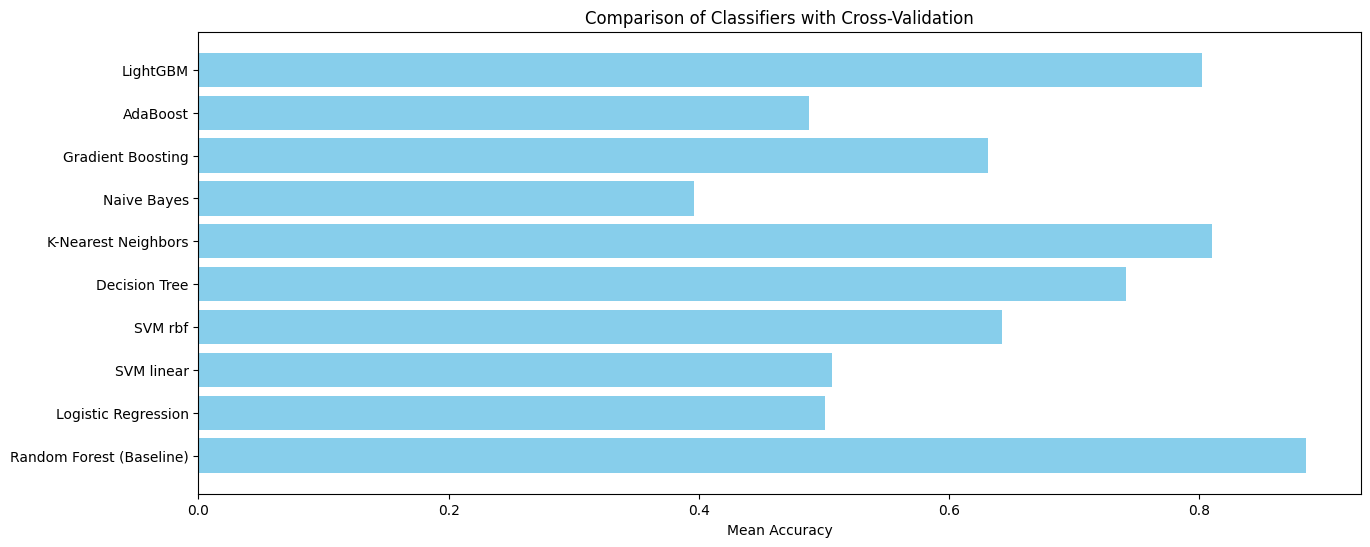

In [43]:
import time

# Define classifiers to test
classifiers = {
    "Random Forest (Baseline)": RandomForestClassifier(random_state=random_state, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1),
    "SVM linear": SVC(kernel='linear', random_state=random_state),
    "SVM rbf": SVC(kernel='rbf', random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "AdaBoost": AdaBoostClassifier(random_state=random_state),
    'LightGBM': lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1),
}

# Initialize an empty dictionary to store the results
results = {}

# Loop through classifiers
for name, clf in classifiers.items():
    # Calculate execute start time
    start = time.time()

    # Define pipeline
    pipeline = Pipeline([
        ('model', clf)
    ])
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(pipeline, X_train_res, y_train_res, scoring='accuracy', cv=5)
    
    # Store mean and standard deviation of scores
    results[name] = (scores.mean(), scores.std())

    # Calculate execute duration
    duration = time.time() - start
    
    # Print results
    print(f"{name}: Mean Accuracy: {scores.mean():.4f}, Standard Deviation: {scores.std():.4f} - Duration: {duration/60:.2f} minutes")

# Optionally, plot the results
names = list(results.keys())
values = [x[0] for x in results.values()]  # Extract the mean accuracy values

plt.figure(figsize=(15, 6))
plt.barh(names, values, color='skyblue')
plt.xlabel('Mean Accuracy')
plt.title('Comparison of Classifiers with Cross-Validation')
plt.show()


We select the models sorted by mean accuracy (above 70%) and reasonable training time.

1. **Random Forest (Baseline)**: 88.54% accuracy, with a standard deviation of 0.0212, and a duration of 0.19 minutes.
2. **K-Nearest Neighbors**: 81.03% accuracy, with a standard deviation of 0.0309, and a duration of 0.03 minutes.
3. **LightGBM**: 80.26% accuracy, with a standard deviation of 0.0413, and a duration of 0.11 minutes.
4. **Decision Tree**: 74.16% accuracy, with a standard deviation of 0.0304, and a duration of 0.59 minutes.


##### Next step: Ensemble Methods

Using these ensemble methods, we could potentially increase the predictive power by combining the strengths of the top-performing individual classifiers.

----

### Experiment 4: Ensemble Methods

We focus on using ensemble methods to combine the predictions of multiple models especially Bagging and Stacking. However, they work best under different conditions and serve different purposes.

##### Bagging:
- **Strengths**: It can reduce overfitting by creating an ensemble of parallel models.
- **Weaknesses**: All base models are of the same type and are trained on different subsets of the training data.
- **Use Case**: Effective when the base model has high variance (like Decision Trees). Bagging can help reduce overfitting and variance by averaging predictions.
  
##### Stacking:
- **Strengths**: Can capture complex patterns by combining predictions from diverse model types, improving the model's performance.
- **Weaknesses**: More computationally expensive and can be prone to overfitting if not carefully tuned.
- **Use Case**: Effective for models with complementary strengths and weaknesses.

##### Implementation
- **For Bagging:** We will use the **RandomForestClassifier** and **Decision Tree** as the base model.
- **For Stacking:** We will use the **K-Nearest Neighbors**, **LightGBM** and new 2 Bagging models as the base model.

In [19]:
## Rewrite latest model as baseline

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

random_state = 55

# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=random_state)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [20]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score


##### Bagging with RandomForest and DecisionTree

In [8]:
# Initialize Bagging with RandomForest
bagging_rf = BaggingClassifier(estimator=RandomForestClassifier(random_state=random_state, n_jobs=-1), 
                               n_estimators=10, random_state=random_state, n_jobs=-1)
bagging_rf_scores = cross_val_score(bagging_rf, X_train_res, y_train_res, cv=5)

print(f"Bagging with Random Forest: Mean Accuracy: {bagging_rf_scores.mean():.4f}, Standard Deviation: {bagging_rf_scores.std():.4f}")


Bagging with Random Forest: Mean Accuracy: 0.8677, Standard Deviation: 0.0224


In [11]:
# Initialize Bagging with DecisionTree
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=random_state), 
                               n_estimators=10, random_state=random_state, n_jobs=-1)
bagging_dt_scores = cross_val_score(bagging_dt, X_train_res, y_train_res, cv=5)

print(f"Bagging with Decision Tree: Mean Accuracy: {bagging_dt_scores.mean():.4f}, Standard Deviation: {bagging_dt_scores.std():.4f}")

Bagging with Decision Tree: Mean Accuracy: 0.8297, Standard Deviation: 0.0235


##### Stacking with K-Nearest Neighbors, LightGBM, and Bagging models

In [13]:
# Define the base models
base_estimators = [
                 ('knn', KNeighborsClassifier(n_jobs=-1)),
                 ('lgbm', lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)),
                 ('bagging_rf', bagging_rf),
                 ('bagging_dt', bagging_dt)
                ]

# Initialize the Stacking Classifier with a Random Forest Regressor as the final estimator
stacking_rf = StackingClassifier(estimators=base_estimators, final_estimator=RandomForestClassifier(random_state=random_state, n_jobs=-1))

# Evaluate the Stacking Classifier
stacking_rf_scores = cross_val_score(stacking_rf, X_train_res, y_train_res, cv=5)

print(f"Stacking with Random Forest: Mean Accuracy: {stacking_rf_scores.mean():.4f}, Standard Deviation: {stacking_rf_scores.std():.4f}")


Stacking with Random Forest: Mean Accuracy: 0.8799, Standard Deviation: 0.0286


In [21]:
from sklearn.linear_model import LogisticRegression

# Initialize the Stacking Classifier with a logistic regression as the final estimator
stacking_lr = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

# Evaluate the Stacking Classifier
stacking_lr_scores = cross_val_score(stacking_lr, X_train_res, y_train_res, cv=5)

print(f"Stacking with Logistic Regression: Mean Accuracy: {stacking_lr_scores.mean():.4f}, Standard Deviation: {stacking_lr_scores.std():.4f}")


Stacking with Logistic Regression: Mean Accuracy: 0.8822, Standard Deviation: 0.0268


In [24]:
# Initialize the Stacking Classifier with a Decision Tree as the final estimator
stacking_dt = StackingClassifier(estimators=base_estimators, final_estimator=DecisionTreeClassifier(random_state=random_state), n_jobs=-1)

# Evaluate the Stacking Classifier
stacking_dt_scores = cross_val_score(stacking_dt, X_train_res, y_train_res, cv=5)

print(f"Stacking with Decision Tree: Mean Accuracy: {stacking_dt_scores.mean():.4f}, Standard Deviation: {stacking_dt_scores.std():.4f}")

Stacking with Decision Tree: Mean Accuracy: 0.8253, Standard Deviation: 0.0235


In [22]:
# Initialize the Voting soft Classifier
voting_soft = VotingClassifier(estimators=base_estimators, voting='soft', n_jobs=-1)

# Evaluate the Voting Classifier
voting_soft_scores = cross_val_score(voting_soft, X_train_res, y_train_res, cv=5)

print(f"Voting Soft Classifier: Mean Accuracy: {voting_soft_scores.mean():.4f}, Standard Deviation: {voting_soft_scores.std():.4f}")

Voting Soft Classifier: Mean Accuracy: 0.8651, Standard Deviation: 0.0241


In [23]:
# Initialize the Voting hard Classifier
voting_hard = VotingClassifier(estimators=base_estimators, voting='hard', n_jobs=-1)

# Evaluate the Voting Classifier
voting_hard_scores = cross_val_score(voting_hard, X_train_res, y_train_res, cv=5)

print(f"Voting Hard Classifier: Mean Accuracy: {voting_hard_scores.mean():.4f}, Standard Deviation: {voting_hard_scores.std():.4f}")

Voting Hard Classifier: Mean Accuracy: 0.8571, Standard Deviation: 0.0252


##### Observations:

The **Stacking with Logistic Regression** method yields the highest mean accuracy of 0.8822 with a standard deviation of 0.0286. It seems to be benefiting from the combined strengths of its base classifiers, as it outperforms each one individually.

##### Next Steps:
- Build final model using Stacking with Logistic Regression
- Test the model with unseen data
- Tune the hyperparameters of the model to improve its performance further


----

### Experiment 5: Test final model

##### Load data and features

In [5]:
df = get_features_target_next_close()

Load modules

In [6]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

In [7]:
# Random state for reproducibility
random_state = 55

# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Data Preprocessing: Splitting and Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Data Augmentation: SMOTE for imbalance handling
sm = SMOTE(random_state=random_state)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [8]:
# Initialize Bagging Classifiers

bagging_rf = BaggingClassifier(estimator=RandomForestClassifier(random_state=random_state, n_jobs=-1),
                               n_estimators=10, random_state=random_state, n_jobs=-1)

bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=random_state),
                               n_estimators=10, random_state=random_state, n_jobs=-1)

# Initialize base estimators for stacking
base_estimators = [
    ('knn', KNeighborsClassifier(n_jobs=-1)),
    ('lgbm', lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)),
    ('bagging_rf', bagging_rf),
    ('bagging_dt', bagging_dt),
    
]

# Initialize the final Stacking Classifier with Logistic Regression as the final estimator
model = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

# Train the final Stacking model
model.fit(X_train_res, y_train_res)

# You can evaluate the model on the test set
y_pred = model.predict(X_test_scaled)

Evaluate the model


Classification Report:
               precision    recall  f1-score   support

          -1       0.78      0.70      0.74      1601
           0       0.78      0.83      0.80      3538
           1       0.77      0.74      0.76      1557

    accuracy                           0.78      6696
   macro avg       0.78      0.76      0.77      6696
weighted avg       0.78      0.78      0.78      6696



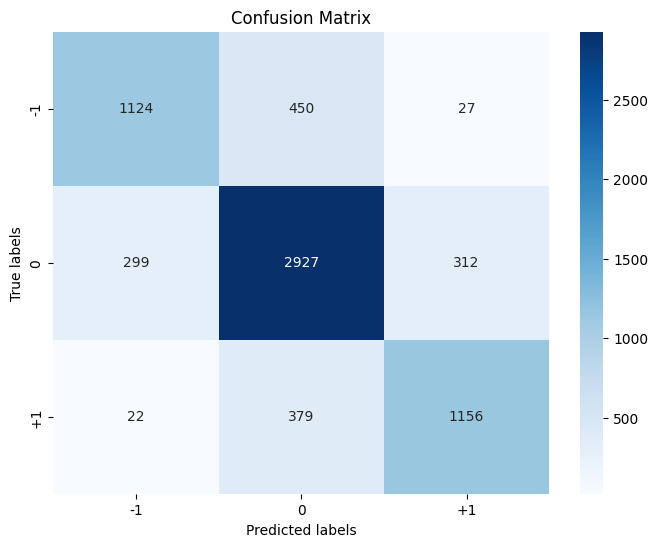

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion report
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['-1', '0', '+1'], 
            yticklabels=['-1', '0', '+1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


The discrepancy between the training performance and the performance on unseen data may be due to a variety of factors. Below are some of the common reasons and corresponding solutions:

##### Overfitting
The model may have overfit to the training data, learning the noise in the training data, but not the actual relationship between the variables.

**Solutions:**
- Try simplifying the model, for example by reducing the number of features or changing hyperparameters.
- Use regularization methods.
  
##### Data Distribution Shift
The distribution of the unseen data may be different from the distribution of the training data.

**Solutions:**
- Make sure that the training and test datasets come from the same distribution.
- Rebalance classes, if needed.

##### Model Robustness
It's also possible that while the model is good at the "average case" in the training data, it may not be robust to outliers or rare events in the unseen data.

**Solutions:**
- Use techniques like bootstrapping to make the model more robust.
- Re-visit feature engineering steps.

----